In [30]:
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root='data/MoleculeNet', name='ESOL')
print(data)

print(f'Dataset type: {type(data)}')
print("Dataset features:", data.num_features)
print("Dataset targets:", data.num_classes)
print("Dataset sample:", data[0])
print("Dataset size:", len(data));

ESOL(1128)
Dataset type: <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features: 9
Dataset targets: 734
Dataset sample: Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Dataset size: 1128


/home/huangzy/miniconda3/envs/uplc/lib/python3.9/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [31]:
print(data[0].x)
print(data[0].edge_index.T)
print(data[0].y)

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

Molecule SMILES: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Type of molecule: <class 'rdkit.Chem.rdchem.Mol'>


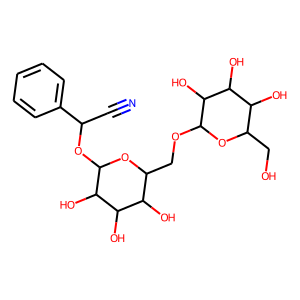

In [32]:
from rdkit import Chem
from rdkit.Chem import Draw

molecule = Chem.MolFromSmiles(data[0]["smiles"])

print("Molecule SMILES:", data[0]["smiles"])
print("Type of molecule:", type(molecule))
Draw.MolToImage(molecule, size=(300, 300))

In [33]:
import torch
import torch.nn as nn
from torch.nn import  Linear

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gmp, global_max_pool as gap 

embedding_size = 64


class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)

        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        self.out = Linear(embedding_size * 2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = hidden.tanh()

        hidden = self.conv1(hidden, edge_index)
        hidden = hidden.tanh()   # 修复：使用torch.tanh()
        hidden = self.conv2(hidden, edge_index)
        hidden = hidden.tanh()   # 修复：使用torch.tanh()
        hidden = self.conv3(hidden, edge_index)
        hidden = hidden.tanh()   # 修复：使用torch.tanh()
        
        hidden = torch.cat([
            gmp(hidden, batch_index),
            gap(hidden, batch_index)
        ], dim=1)

        out = self.out(hidden)

        return out, hidden
    
model = GCN()
model.to('cuda' if torch.cuda.is_available() else 'cpu')
print(model)

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [34]:
from torch_geometric.loader import DataLoader

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

data_size = len(data)
batch_size = 128
train_loader = DataLoader(data[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=batch_size, shuffle=False)

In [45]:
def train(data):
    model.train()  # 设置为训练模式
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # 关键修复：将输入数据转换为float类型
        x = batch.x.float()
        edge_index = batch.edge_index
        batch_idx = batch.batch
        y = batch.y.float()

        x, edge_index, batch_idx, y = x.to('cuda'), edge_index.to('cuda'), batch_idx.to('cuda'), y.to('cuda')

        pred, embeding = model(x, edge_index, batch_idx)
        loss = torch.sqrt(loss_fn(pred, y))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader), embeding

print("Training started...")
losses = []
for epoch in range(5000):
    loss, h = train(data)
    losses.append(loss)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Training started...
Epoch 0, Loss: 0.5618893913924694


/home/huangzy/miniconda3/envs/uplc/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 100, Loss: 0.5832422450184822
Epoch 200, Loss: 0.5205188989639282
Epoch 300, Loss: 0.5397921726107597
Epoch 400, Loss: 0.515830509364605
Epoch 500, Loss: 0.5400519482791424
Epoch 600, Loss: 0.5500647611916065
Epoch 700, Loss: 0.568241685628891
Epoch 800, Loss: 0.5507400892674923
Epoch 900, Loss: 0.5312607623636723
Epoch 1000, Loss: 0.5201357193291187
Epoch 1100, Loss: 0.5258869454264641
Epoch 1200, Loss: 0.5192397274076939
Epoch 1300, Loss: 0.4808469582349062
Epoch 1400, Loss: 0.48389220610260963
Epoch 1500, Loss: 0.5619260966777802
Epoch 1600, Loss: 0.5048248916864395
Epoch 1700, Loss: 0.531379908323288
Epoch 1800, Loss: 0.565544456243515
Epoch 1900, Loss: 0.4926394857466221
Epoch 2000, Loss: 0.504949051886797
Epoch 2100, Loss: 0.49416398629546165
Epoch 2200, Loss: 0.4768538251519203
Epoch 2300, Loss: 0.4772508144378662
Epoch 2400, Loss: 0.4953153170645237
Epoch 2500, Loss: 0.4802086800336838
Epoch 2600, Loss: 0.5105177275836468
Epoch 2700, Loss: 0.4755556248128414
Epoch 2800, L

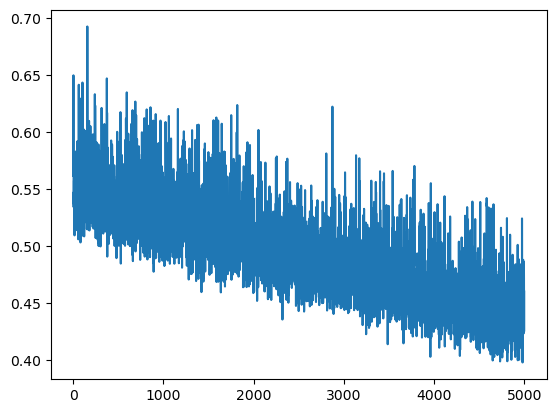

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
sns.lineplot(losses_float)
plt.show()

In [50]:
import pandas as pd

# 推理
def predict(data):
    model.eval()  # 设置为评估模式
    with torch.no_grad():
        x = data.x.float().to('cuda')
        edge_index = data.edge_index.to('cuda')
        batch_idx = data.batch.to('cuda')

        pred, _ = model(x, edge_index, batch_idx)
        return pred.cpu().numpy()
    
# 修复测试函数
def test(data):
    model.eval()  # 设置为评估模式
    
    # 创建空的DataFrame来存储所有结果
    all_results = []
    
    with torch.no_grad():
        total_loss = 0
        for batch in test_loader:
            x = batch.x.float().to('cuda')
            edge_index = batch.edge_index.to('cuda')
            batch_idx = batch.batch.to('cuda')
            y = batch.y.float().to('cuda')

            pred, _ = model(x, edge_index, batch_idx)
            loss = torch.sqrt(loss_fn(pred, y))
            total_loss += loss.item()

            # 修复：确保数据是1D的
            smiles = batch.smiles
            pred_values = pred.cpu().numpy().flatten()  # 确保是1D
            actual_values = y.cpu().numpy().flatten()   # 确保是1D
            
            # 创建当前batch的结果
            batch_results = pd.DataFrame({
                'smiles': smiles,
                'predicted': pred_values,
                'actual': actual_values
            })
            
            all_results.append(batch_results)

        # 合并所有结果并保存
        final_results = pd.concat(all_results, ignore_index=True)
        final_results.to_csv('predictions.csv', index=False)
        
        return total_loss / len(test_loader)
    
test_loss = test(data)
print(f'Test Loss: {test_loss}')

Test Loss: 0.7756483852863312
